In [1]:
from utlities.cal_utils import Format, Analyze 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

import seaborn as sns
import math
import scipy
from scipy.signal import find_peaks
import numpy as np
import os

rep = "3"

path_data = f"./Data/rep{rep}_data.xlsx"
path_md = f"./Data/rep{rep}_md.xlsx"


folder = f"./picker_outputs_rep{rep}"

option_graphs_folder_for_11mm = f"rep{rep}_11mM_option_graphs"
complete_graphs = f"rep{rep}_11mM_complete__graphs"

form = Format(path = path_data)
analyze = Analyze()

sns.set_style("darkgrid")
sns.color_palette('colorblind')


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [2]:
if not os.path.exists(folder): 
      
    # if the demo_folder directory is not present  
    # then create it. 
    os.makedirs(folder) 

In [3]:
"""This cell makes the original data for this rep tidy,  calculated the normalized AU, and saves it to an exterior excel file"""

if not os.path.exists(f'{folder}/Rep{rep}_df.csv'):

    df = form.tidy_file(delta = False, average = True)
    df.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)
    

In [4]:
#load the tidy excel file made in the previous cell
df = pd.read_csv(f'{folder}/Rep{rep}_df.csv')


#load in the start times for different stimulus
md = pd.read_excel(path_md)


If there are multiple average lines on one plot and another plot is missing, it is becasue the missing plot is mislabeled on the spreadsheet as a different plot name

In [5]:
if not os.path.exists(f'{folder}/{option_graphs_folder_for_11mm}'): 
      
    # if the demo_folder directory is not present then create it
                      
    os.makedirs(f'{folder}/{option_graphs_folder_for_11mm}')

In [6]:
from math import log10, floor
def round_sig(x, sig=1, small_value=1.0e-9):
    rounded = round(x, sig - int(floor(log10(max(abs(x), abs(small_value))))) - 1)

    return rounded

In [7]:
treatments = df.Treatment.unique()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

dfs = []
# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):

    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    cells = temp_df["Cell #"].unique()

    #re-iniitialize the color pallet with each new set of plots:
    palette = sns.color_palette("colorblind", len(cells))

    #initialize plot
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.9)

    for m, cell in enumerate(cells):
        

        
        wind_start = temp_md["11 mM Stimulus"].iloc[0]
        wind_end = temp_md["20 mM Stimulus"].iloc[0]


        plot_df = temp_df[temp_df["Cell #"] == cell]
        plot_df = plot_df[plot_df["Time (sec)"].between(wind_start, wind_end)]

        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)
        #ax = plt.gca()
        # filter df and plot ticker on the new subplot axis

        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("A.U.")
        #ax.legend()
        #ax.get_legend().remove()
        #ax.set_xlabel("")

        #sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m], alpha = 0.75)
        # Set more frequent ticks on the x-axis
        au_change = plot_df["Normalized A.U."].max() - plot_df["Normalized A.U."].min()
        time_change = plot_df["Time (sec)"].max() - plot_df["Time (sec)"].min()
        

        window = 4
        loops = 3


     
        mode = "smooth"
        #sns.lineplot(data = plot_df,x = "Time (sec)", y = "Smoothed Normalized A.U.", color=palette[m])

        if mode == "detailed":
            # Designing a Butterworth IIR filter for smoothing
            order = 3  # Filter order
            #note: adjust cutoff_freq to adjust smoothing
            cutoff_freq = 0.3  # Cutoff frequency, needs to be fine-tuned based on the data
            # Using a Butterworth low-pass filter
        
        if mode == "medium":
            # Designing a Butterworth IIR filter for smoothing
            order = 3  # Filter order
            #note: adjust cutoff_freq to adjust smoothing
            cutoff_freq = 0.2  # Cutoff frequency, needs to be fine-tuned based on the data
            # Using a Butterworth low-pass filter

        if mode == "smooth":
            #smoothest reasonable settings:
            order = 4  # Filter order
            cutoff_freq = 0.02

        b, a = scipy.signal.iirfilter(N=order, Wn=cutoff_freq, btype='low', ftype='butter')
        # Applying the filter to the Cell 1 data
        smoothed_AU = scipy.signal.filtfilt(b, a, plot_df["Normalized A.U."])
        plot_df.insert(2, "Smoothed Normalized A.U.", smoothed_AU ,True)
   
        
        #sns.lineplot(data = plot_df,x = "Time (sec)", y = "Smoothed Normalized A.U.", color=palette[m])


       
      


        sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m], alpha = 0.6)
        sns.lineplot(data = plot_df,x = "Time (sec)", y = "Smoothed Normalized A.U.", color=palette[m], alpha = 1)

      
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))  # Adjust the locator value as needed

        yspacing = round_sig((plot_df["Normalized A.U."].max()/20))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(yspacing)) 
        ax.tick_params(axis='x', labelsize=10)  # Adjust the font size of x-axis tick labels
        ax.tick_params(axis='y', labelsize=10)  # Adjust the font size of x-axis tick labels

        #time_point = plot_df[plot_df["Smoothed Normalized A.U."] == plot_df["Smoothed Normalized A.U."].max()]["Time (sec)"].iloc[0]
      
        #au = plot_df[plot_df["Time (sec)"] == time_point]["Smoothed Normalized A.U."].iloc[0]

        #ax.plot(time_point, au, marker="o", color="black", markersize=3)

 
        
        inverted_signal = -plot_df["Smoothed Normalized A.U."].values
        min_locations = find_peaks(inverted_signal, distance=5, prominence=0.08)[0]
        for location in min_locations:
        
            time = plot_df.iloc[location]["Time (sec)"]
            au = plot_df.iloc[location]["Smoothed Normalized A.U."]
           
            ax.plot(time, au, marker="o", color="green", markersize=3)

        max_locations = find_peaks(plot_df["Smoothed Normalized A.U."], distance=10, height = 3, prominence=0.1)[0][:3] #width=(30,10000), height = 3, prominence=0.35
        widths = scipy.signal.peak_widths(plot_df["Smoothed Normalized A.U."], max_locations)[0]
       

        """   
        if len(max_locations) > 1 and widths[0] > widths[1]:
            max_locations = [max_locations[0]]
        elif len(max_locations) > 1:
            max_locations = [max_locations[1]]"""


        #end = (0,np.inf)

        ends = []
        for location in max_locations:
        
            time = plot_df.iloc[location]["Time (sec)"]
            au = plot_df.iloc[location]["Smoothed Normalized A.U."]
           
            ax.plot(time, au, marker="o", color="red", markersize=3)

            for l in min_locations:
                if l > location:
                    time = plot_df.iloc[l]["Time (sec)"]
                    au = plot_df.iloc[l]["Smoothed Normalized A.U."]
                    #if au < end[1]:
                    ends.append((time, au))
                    ax.axvline(x=time, color='grey')
                    break
                
                    
        
        cell_md_cop = temp_md.copy()

        if len(ends) == 0:

            if len(min_locations) > 0:
                time1 = plot_df.iloc[min_locations[0]]["Time (sec)"]
                ax.axvline(x=time, color='grey')
            
            else:
                time1 = np.nan
    
            if len(min_locations) > 1:
                time2 = plot_df.iloc[min_locations[1]]["Time (sec)"]
                ax.axvline(x=time2, color='grey')
            
            else:
                time2 = np.nan
            
            if len(min_locations) > 2:
                time2 = plot_df.iloc[min_locations[2]]["Time (sec)"]
                ax.axvline(x=time3, color='grey')
            
            else:
                time3 = np.nan

            cell_md_cop["End Option 1"] = time1
            cell_md_cop["End Option 2"] = time2
            cell_md_cop["End Option 3"] = time3

        
        elif len(ends) == 1:

            cell_md_cop["End Option 1"] = int(ends[0][0])
            cell_md_cop["End Option 2"] = np.nan
            cell_md_cop["End Option 3"] = np.nan


            if len(min_locations) > 1:
                time2 = plot_df.iloc[min_locations[1]]["Time (sec)"]
                ax.axvline(x=time2, color='grey')
                cell_md_cop["End Option 2"] = time2

            if len(min_locations) > 2:
                time3 = plot_df.iloc[min_locations[2]]["Time (sec)"]
                ax.axvline(x=time3, color='grey')
                cell_md_cop["End Option 3"] = time3
        #new_md.at[row_ind, '11 mM End'] = end[0]
            
        elif len(ends) == 2:
            cell_md_cop["End Option 1"] = int(ends[0][0])
            cell_md_cop["End Option 2"] = int(ends[1][0])
            cell_md_cop["End Option 3"] = np.nan

            if len(min_locations) > 2:
                time3 = plot_df.iloc[min_locations[2]]["Time (sec)"]
                ax.axvline(x=time3, color='grey')
                cell_md_cop["End Option 3"] = time3
                
        elif len(ends) > 2:
            cell_md_cop["End Option 1"] = int(ends[0][0])
            cell_md_cop["End Option 2"] = int(ends[1][0])
            cell_md_cop["End Option 3"] = int(ends[2][0])

        cell_md_cop["Represent"] = "TRUE"



        dfs.append(cell_md_cop)

        # Enable and enlarge minor ticks for visibility
        ax.minorticks_on()
        # Add minor ticks on the x-axis
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
        ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5)

        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
        #ax.tick_params(axis='y', which='minor', bottom=True, top=False, length=5)


        ax.set_xlabel("Time (sec)", fontsize=12)
        ax.set_ylabel("A.U.", fontsize=12)
        # chart formatting
        ax.set_title(f"{treat.upper()} \n {cell}")
        
        

    plt.savefig(f"{folder}/{option_graphs_folder_for_11mm}/Rep{rep}_{treat}_graphs.png", bbox_inches = "tight");
    plt.close()
new_md = pd.concat(dfs)
new_md["Quality"] = ""
new_md["11 mM End"] = ""
new_md["Notes"] = ""



    
new_md.to_excel(f"{folder}/options_rep{rep}.xlsx")


In [8]:

new_md

,Treatment,11 mM Stimulus,20 mM Stimulus,KCL Stimulus,11 mM End,End Option 1,End Option 2,End Option 3,Represent,Quality,Notes
0,NoRTG NoInh - Islet 1,240,1860,2940,,372.000,955.00,1118.0,TRUE,,
0,NoRTG NoInh - Islet 1,240,1860,2940,,542.000,1032.00,1188.0,TRUE,,
0,NoRTG NoInh - Islet 1,240,1860,2940,,371.000,1029.00,1601.0,TRUE,,
0,NoRTG NoInh - Islet 1,240,1860,2940,,694.000,1087.00,1569.0,TRUE,,
0,NoRTG NoInh - Islet 1,240,1860,2940,,449.000,1047.00,1204.0,TRUE,,
...,...,...,...,...,...,...,...,...,...,...,...
9,10wt% RTG NoInh - Islet 2,240,1380,2340,,521.885,769.23,NaN,TRUE,,
9,10wt% RTG NoInh - Islet 2,240,1380,2340,,797.000,973.00,NaN,TRUE,,
9,10wt% RTG NoInh - Islet 2,240,1380,2340,,695.000,1036.00,NaN,TRUE,,
9,10wt% RTG NoInh - Islet 2,240,1380,2340,,802.000,1155.14,NaN,TRUE,,


In [9]:
if not os.path.exists(f'{folder}/{complete_graphs}'): 
      
    # if the demo_folder directory is not present then create it
                      
    os.makedirs(f'{folder}/{complete_graphs}')

In [10]:
treatments = df.Treatment.unique()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):

    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    cells = temp_df["Cell #"].unique()

    #re-iniitialize the color pallet with each new set of plots:
    palette = sns.color_palette("colorblind", len(cells))

    #initialize plot
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.887)

    for m, cell in enumerate(cells):

        plot_df = temp_df[temp_df["Cell #"] == cell]

        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)


        #if there is no metadata
        if len(temp_md) == 0:
            print(f"There is no metadata on {treat} so no starts or ends of curves are unknown")
            continue

        #if we have metadata on the cell
        else:
            # filter df and plot ticker on the new subplot axis
            ax.axvline(x=temp_md["11 mM Stimulus"].iloc[0], color='grey')
            ax.axvline(x=temp_md["20 mM Stimulus"].iloc[0], color='grey')

            # Text labels
            y_pos = ax.get_ylim()[0]  # Position at the bottom of the graph
            ax.text(temp_md["11 mM Stimulus"].iloc[0], y_pos, "11mM Start", color='grey', verticalalignment='bottom')
            ax.text(temp_md["20 mM Stimulus"].iloc[0], y_pos, "20mM Start", color='grey', verticalalignment='bottom')

            ax.set_xlabel("Time (sec)")
            ax.set_ylabel("A.U.")
            #ax.legend()
            #ax.get_legend().remove()
            #ax.set_xlabel("")

            sns.lineplot(data = plot_df,x = "Time (sec)", y = "Normalized A.U.", color=palette[m])
            # Set more frequent ticks on the x-axis

            xspacing = int(round_sig((plot_df["Time (sec)"].max() - plot_df["Time (sec)"].min())/20))
            ax.xaxis.set_major_locator(ticker.MultipleLocator(xspacing))  # Adjust the locator value as needed
            yspacing = round_sig((plot_df["Normalized A.U."].max()/10))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(yspacing)) 
            ax.tick_params(axis='x', labelsize=10)  # Adjust the font size of x-axis tick labels
            ax.tick_params(axis='y', labelsize=10)  # Adjust the font size of x-axis tick labels

            # Enable and enlarge minor ticks for visibility
            ax.minorticks_on()
            # Add minor ticks on the x-axis
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adds 1 minor tick between major ticks
            ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5)


            ax.set_xlabel("Time (sec)", fontsize=12)
            ax.set_ylabel("A.U.", fontsize=12)
            # chart formatting
            ax.set_title(f"{treat.upper()} \n {cell}")

    plt.savefig(f"{folder}/{complete_graphs}/rep{rep}_{treat}_graphs.png", bbox_inches = "tight")
    plt.close();


In [11]:
md = analyze.AUC(md, df, style="rect")
md = analyze.AUC(md, df, style="trap")

In [12]:
md["Duty"] = (md["11 mM Stimulus"] - md["11 mM End"])/(md["11 mM End"] - md["20 mM Stimulus"])

In [13]:
df[df["Treatment"] == treat]

,Time (sec),[hr]:[min]:[sec],A.U.,Normalized A.U.,Cell #,Treatment
435945,1.295,00:00:01.295000,5.000000,1.000000,Cell 1,10wt% RTG NoInh - Islet 2
435946,2.590,00:00:02.590000,4.778000,0.955600,Cell 1,10wt% RTG NoInh - Islet 2
435947,3.885,00:00:04,4.778000,0.955600,Cell 1,10wt% RTG NoInh - Islet 2
435948,5.180,00:00:05.180000,5.222000,1.044400,Cell 1,10wt% RTG NoInh - Islet 2
435949,6.475,00:00:06.475000,5.444000,1.088800,Cell 1,10wt% RTG NoInh - Islet 2
...,...,...,...,...,...,...
455420,2517.480,00:41:57.480000,3.331500,0.538120,AVG,10wt% RTG NoInh - Islet 2
455421,2518.775,00:41:58.775000,3.166625,0.511488,AVG,10wt% RTG NoInh - Islet 2
455422,2520.070,00:42:00.070000,3.267250,0.527742,AVG,10wt% RTG NoInh - Islet 2
455423,2521.365,00:42:01.365000,3.199500,0.516799,AVG,10wt% RTG NoInh - Islet 2


In [14]:
md_plot = md.copy()

md_plot["Treatment"] = md_plot["Treatment"].str.split("-", n = 1, expand = True)[0]




In [15]:
md_plot.to_excel(f"{folder}/Rep{rep}_11mM_curve_raw_calculations.xlsx")

Area under the curve was calculated by normalizing the data, subtracting the values of the curve by the starting value, and then using a trapazoid AUC but could easily to rectangular. The error bars depicted are a 95 percent confidence interval but I can change this.

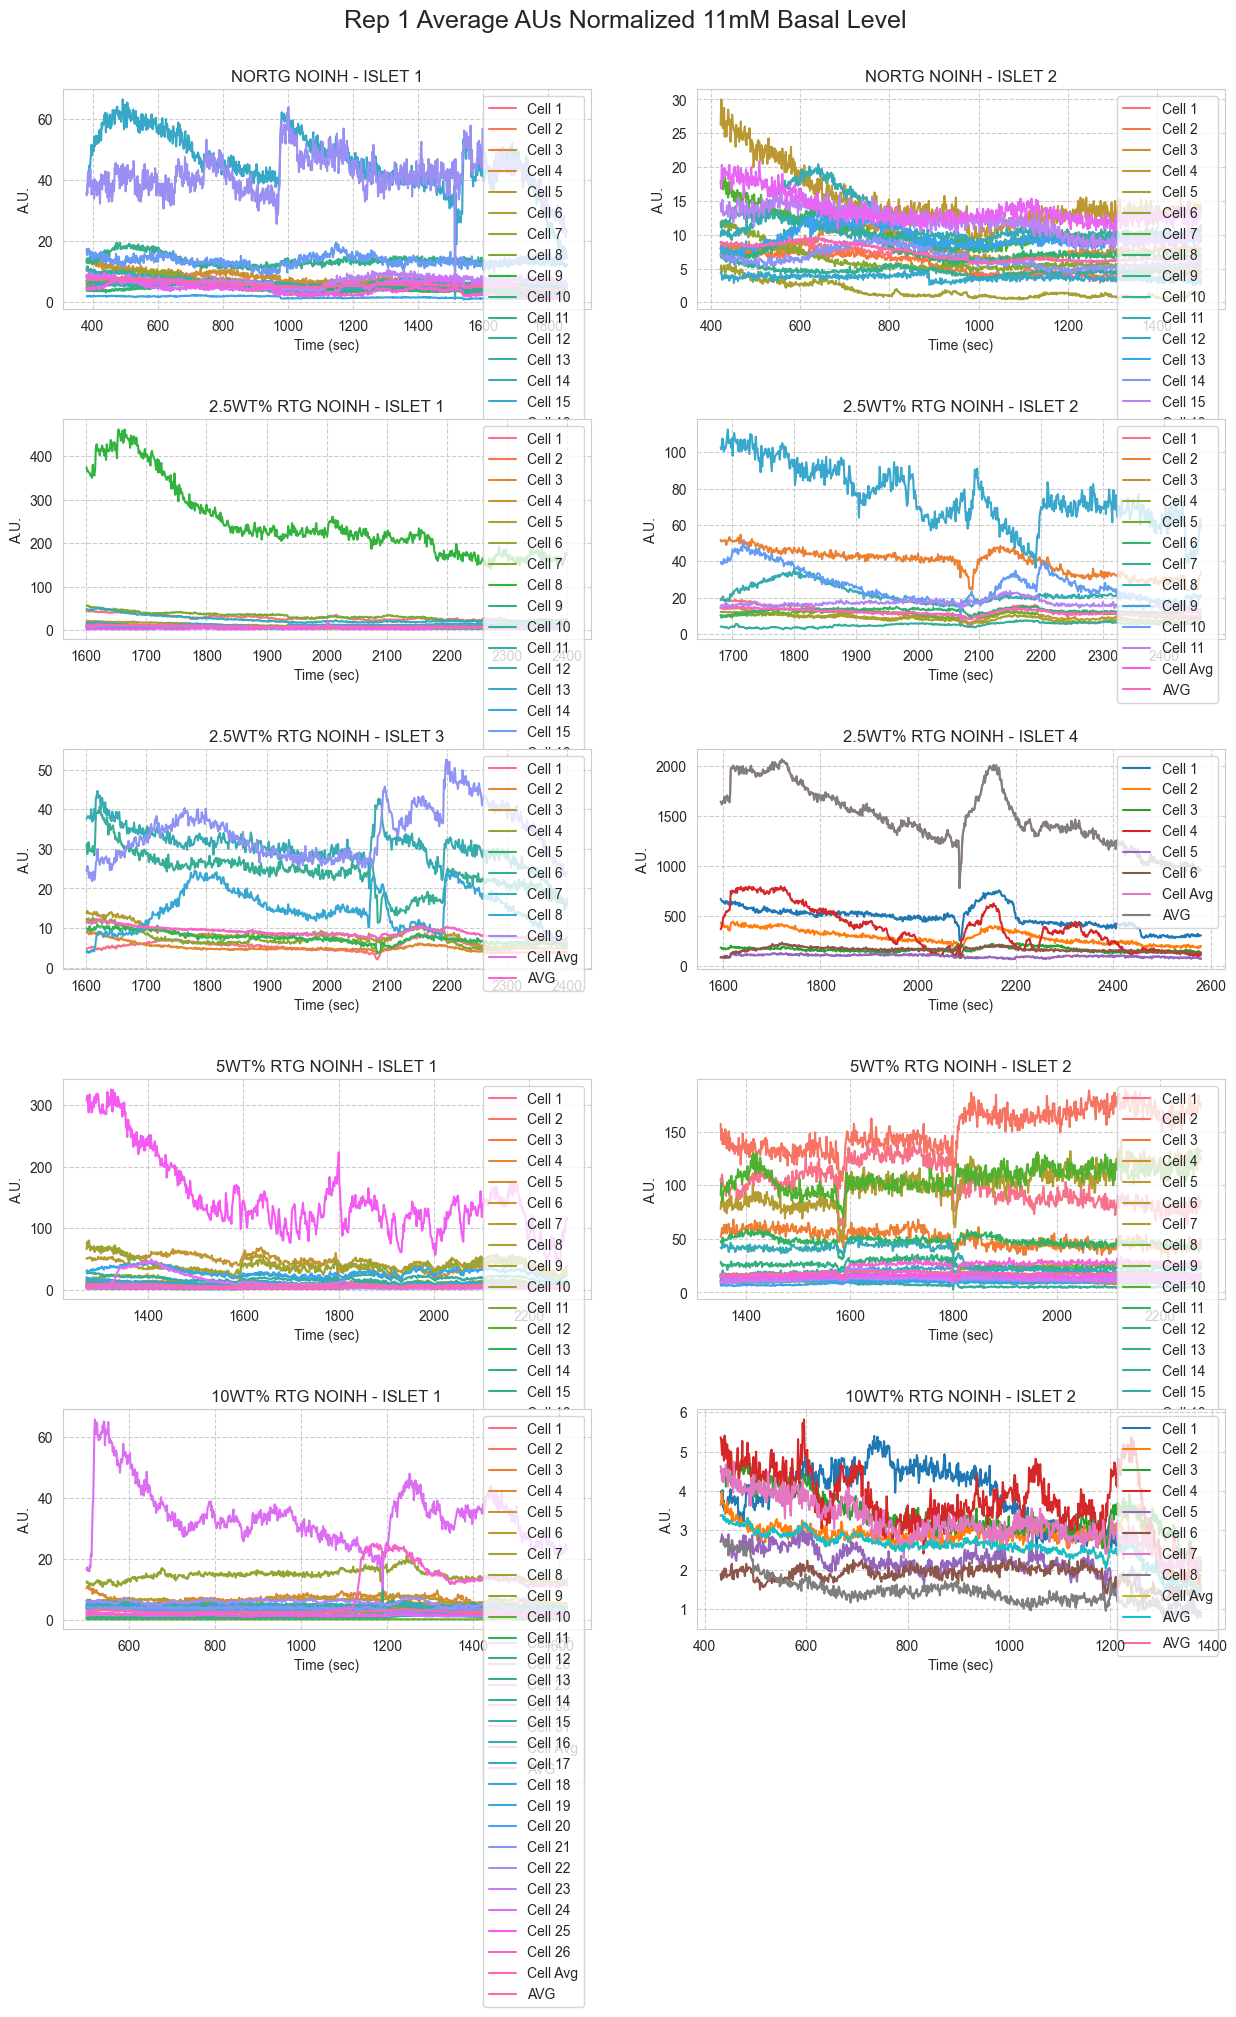

In [16]:
treatments = df.Treatment.unique()

plt.figure(figsize=(15, int(2*len(treatments))))
plt.subplots_adjust(hspace=.5)
plt.suptitle("Rep 1 Average AUs Normalized 11mM Basal Level", fontsize=18, y=0.92)

# loop through the length of tickers and keep track of index
for n, treat in enumerate(treatments):


    ax = plt.subplot(int(math.ceil(len(treatments)/2)), 2, n + 1)


    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    temp_df = temp_df[temp_df["Time (sec)"].between(temp_md["11 mM End"].iloc[0], temp_md["20 mM Stimulus"].iloc[0])]

    
    # filter df and plot ticker on the new subplot axis
    sns.lineplot(data = temp_df,x = "Time (sec)", y = "Normalized A.U.", hue = "Cell #")

    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("A.U.")


    # chart formatting
    ax.set_title(treat.upper())
    ax.legend()
    #ax.get_legend().remove()
    #ax.set_xlabel("")
plt.savefig(f"{folder}/Rep{rep}_11mM_curve_boundaries_displayed.png", bbox_inches = "tight");



    
    